In [1]:
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple, to_plot
from snn_delays.utils.test_behavior import tb_addtask_refact
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 20
batch_size = 32 # 128: anil kag

ckpt_dir = 'multiaddtask_04_2025_tests'

dataset = 'copymemory_episodic'

num_epochs = 3000 # important: epochs here refer to iteration steps

dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3

for img, lbl in train_loader:
    print(img.shape)
    print(lbl.shape)
    break

Initializing GPU cache for 96000 samples...
Cache initialized in 8.99 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds
torch.Size([32, 20, 3])
torch.Size([32, 2, 2])


In [3]:
num_h = 64

tau_m = 'log-uniform'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=3, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=2, bias=False)
    )
  )
)

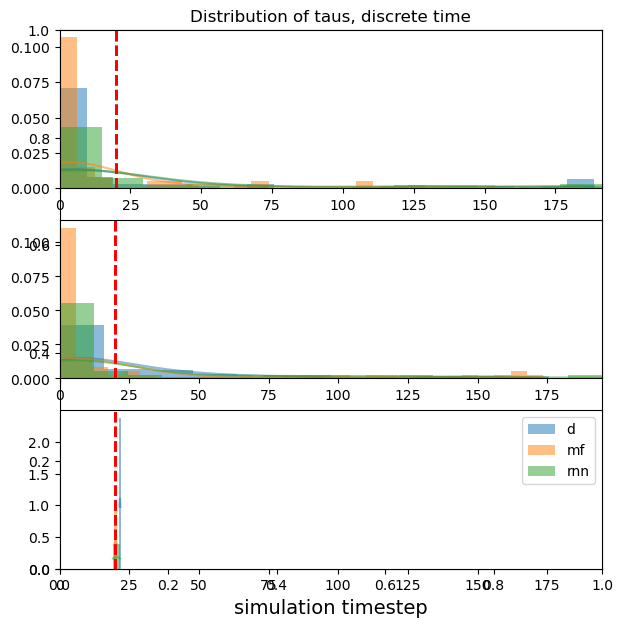

In [4]:
from snn_delays.utils.visualization_utils import plot_taus_refact, plot_param

import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot_taus_refact(snn_rd, label='d')
plot_taus_refact(snn_f, label='mf')
plot_taus_refact(snn_rnn, label='rnn')
plt.legend()

Trainable tau

In [5]:
lr_tau = 1.0
train(snn_f, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100)
train(snn_rnn, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100)
train(snn_rd, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100)

Epoch [1/1], learning_rates 0.001000, 1.000000
Step [30/3000], Loss: 0.14104
Step [60/3000], Loss: 0.09725
Step [90/3000], Loss: 0.05610
Step [120/3000], Loss: 0.07669
Step [150/3000], Loss: 0.07827
Step [180/3000], Loss: 0.06607
Step [210/3000], Loss: 0.07419
Step [240/3000], Loss: 0.05405
Step [270/3000], Loss: 0.06575
Step [300/3000], Loss: 0.06434
Step [330/3000], Loss: 0.06834
Step [360/3000], Loss: 0.06398
Step [390/3000], Loss: 0.07508
Step [420/3000], Loss: 0.06071
Step [450/3000], Loss: 0.05213
Step [480/3000], Loss: 0.06165
Step [510/3000], Loss: 0.05162
Step [540/3000], Loss: 0.05270
Step [570/3000], Loss: 0.03335
Step [600/3000], Loss: 0.03433
Step [630/3000], Loss: 0.03566
Step [660/3000], Loss: 0.03194
Step [690/3000], Loss: 0.03148
Step [720/3000], Loss: 0.03930
Step [750/3000], Loss: 0.03535
Step [780/3000], Loss: 0.02760
Step [810/3000], Loss: 0.02736
Step [840/3000], Loss: 0.02135
Step [870/3000], Loss: 0.02150
Step [900/3000], Loss: 0.02537
Step [930/3000], Loss: 0.0

Text(0.5, 1.0, 'train loss')

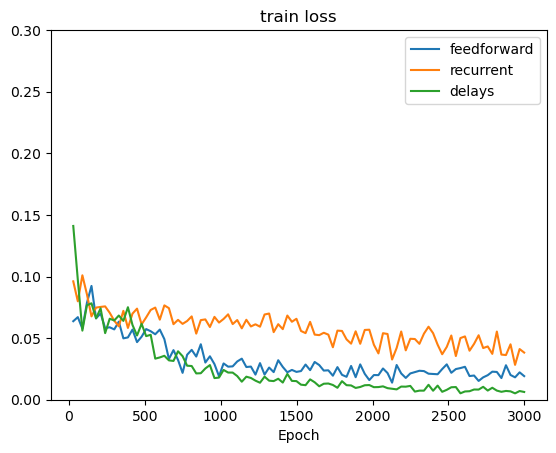

In [6]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 0.3)
plt.title('train loss')

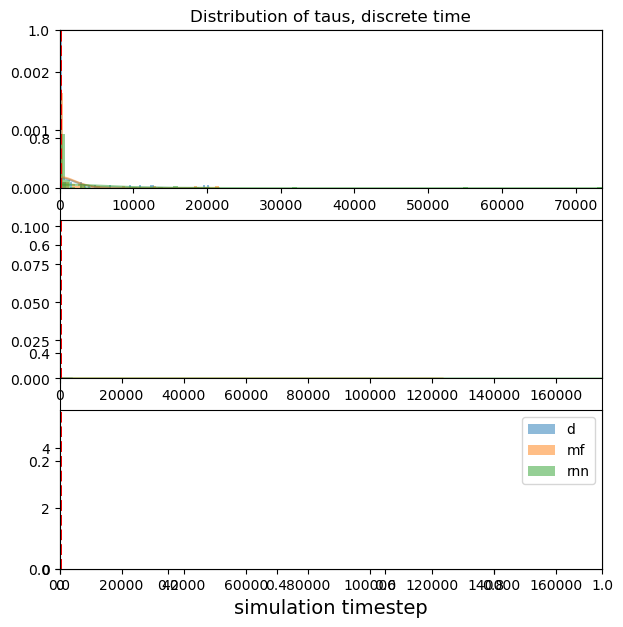

In [7]:
plt.figure(figsize=(7,7))
plot_taus_refact(snn_rd, label='d')
plot_taus_refact(snn_f, label='mf')
plot_taus_refact(snn_rnn, label='rnn')
plt.legend()

Frozen taus

In [8]:
num_h = 64

tau_m = 'log-uniform'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

lr_tau = 1.0
train(snn_f, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)
train(snn_rnn, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)
train(snn_rd, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)

Epoch [1/1], learning_rates 0.001000, 1.000000
Step [30/3000], Loss: 0.05058
Step [60/3000], Loss: 0.06179
Step [90/3000], Loss: 0.05427
Step [120/3000], Loss: 0.06269
Step [150/3000], Loss: 0.04699
Step [180/3000], Loss: 0.04175
Step [210/3000], Loss: 0.03571
Step [240/3000], Loss: 0.03722
Step [270/3000], Loss: 0.03845
Step [300/3000], Loss: 0.03130
Step [330/3000], Loss: 0.03381
Step [360/3000], Loss: 0.03620
Step [390/3000], Loss: 0.04118
Step [420/3000], Loss: 0.03291
Step [450/3000], Loss: 0.03062
Step [480/3000], Loss: 0.02549
Step [510/3000], Loss: 0.03615
Step [540/3000], Loss: 0.02515
Step [570/3000], Loss: 0.02446
Step [600/3000], Loss: 0.02378
Step [630/3000], Loss: 0.02637
Step [660/3000], Loss: 0.02059
Step [690/3000], Loss: 0.02383
Step [720/3000], Loss: 0.01728
Step [750/3000], Loss: 0.01649
Step [780/3000], Loss: 0.01737
Step [810/3000], Loss: 0.01718
Step [840/3000], Loss: 0.02240
Step [870/3000], Loss: 0.02407
Step [900/3000], Loss: 0.01859
Step [930/3000], Loss: 0.0

Text(0.5, 1.0, 'train loss')

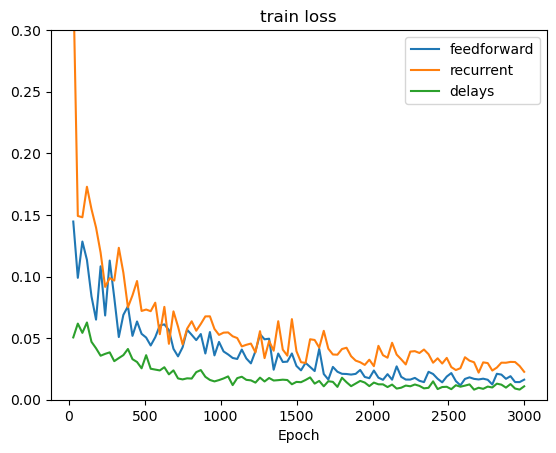

In [9]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 0.3)
plt.title('train loss')

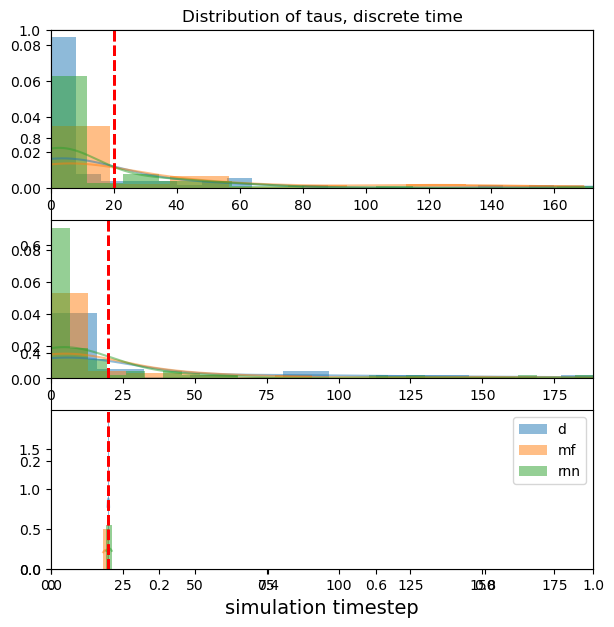

In [10]:
from snn_delays.utils.visualization_utils import plot_taus_refact
plt.figure(figsize=(7,7))
plot_taus_refact(snn_rd, label='d')
plot_taus_refact(snn_f, label='mf')
plot_taus_refact(snn_rnn, label='rnn')
plt.legend()